# External evidence

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
with open("../data/eprints_repos.txt", "r") as f:
    eprints_repos = f.read().split("\n")

In [3]:
data_dir = "../data/analysis"

Merging info from all repos

In [4]:
dfs = []
for eprints_repo in eprints_repos:
    try:
        urls = pd.read_csv(os.path.join(data_dir, "cleaned_links", f"cleaned_urls_{eprints_repo}_2010-_github.com.csv"))
        metadata = pd.read_csv(os.path.join(data_dir, "eprints_pub", f"extracted_pdf_urls_{eprints_repo}_2010-.csv"))
    except FileNotFoundError:
        continue
    metadata["date"] = pd.to_datetime(metadata.date, errors="coerce")
    metadata["year"] = metadata.date.dt.year
    df = pd.merge(urls, metadata, how="right", on=["title", "author_for_reference", "pdf_url"])
    df["eprints_repo"] = eprints_repo
    dfs.append(df)
df = pd.concat(dfs)  # might contain duplicates

Data cleaning

In [5]:
def clean_dataset(df, remove_duplicate_pdf_mentions, remove_duplicate_pub_mentions):
    """Perform data cleaning steps.

    Args:
        df (pd.DataFrame): dataset
        remove_duplicate_pdf_mentions (bool): if True, drop duplicate links in one PDF
        remove_duplicate_pub_mentions (bool): if True, drop duplicate links ocurring on the same page in different PDF links (across repos), and also all duplicates of publications with no links

    Returns:
        pd.DataFrame: cleaned dataset
    """
    df = df[df.year <= datetime.now().year]
    df = df.astype({"year": int})
    # drop duplicate links in one PDF
    if remove_duplicate_pdf_mentions:
        df = df.drop_duplicates(subset=["title", "author_for_reference", "pdf_url", "github_user_cleaned_url"])
    # drop duplicate links ocurring on the same page in different PDF links (across repos), and also all duplicates of publications with no github links
    if remove_duplicate_pub_mentions:
        df = df.drop_duplicates(subset=["title", "author_for_reference", "page_no", "github_user_cleaned_url"])
    return df


In [6]:
df = clean_dataset(df, True, True)

Total number of GitHub URLs in ePrints per year:

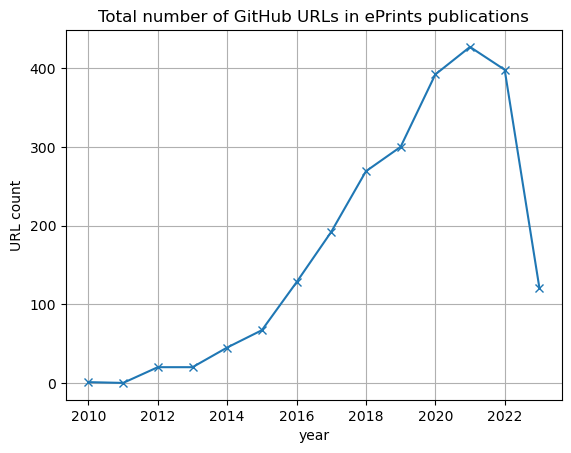

In [16]:
urls_per_year = df.groupby("year")['github_user_cleaned_url'].count()
urls_per_year.plot(
    xlabel="year",
    ylabel="URL count",
    title="Total number of GitHub URLs in ePrints publications",
    marker="x",
    grid=True
)
plt.savefig("../data/analysis/overall/github_in_eprints.png")

Average number of GitHub URLs in an ePrints publication:

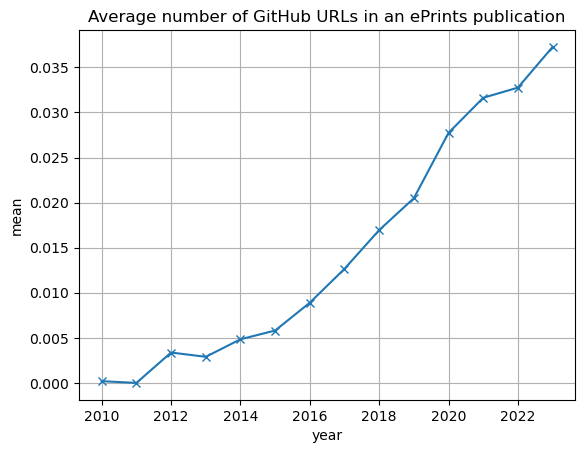

In [68]:
urls_per_publication = df.groupby(["year", "title", "author_for_reference", "pdf_url"])["github_user_cleaned_url"].count().rename("url_count")
urls_per_publication.groupby("year").mean().plot(
    xlabel="year",
    ylabel="mean",
    title="Average number of GitHub URLs in an ePrints publication",
    marker="x",
    grid=True
)
plt.savefig("../data/analysis/overall/avg_github_in_eprints.png")

Number of publications in ePrints that have at least one GitHub URL:

/tmp/ipykernel_25083/2004925619.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 10**6])


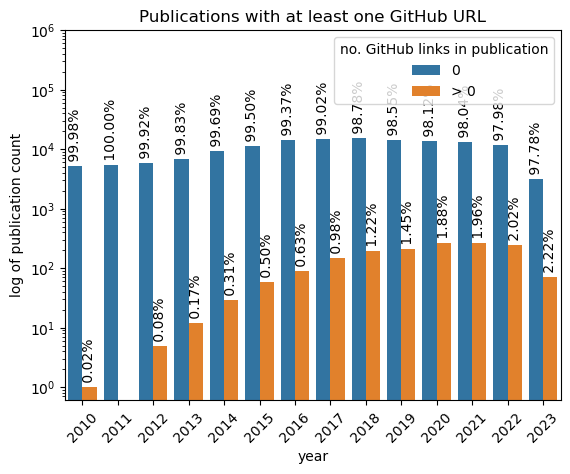

In [113]:
min_one_url = (urls_per_publication > 0).rename("min_one_url").groupby("year").value_counts().rename("pub_count").reset_index()
min_one_url = min_one_url.set_index(["year", "min_one_url"])
new_index = pd.MultiIndex.from_product(min_one_url.index.levels)
min_one_url = min_one_url.reindex(new_index).fillna(0).astype(int)
min_one_url = min_one_url.merge(min_one_url.groupby("year").pub_count.sum().rename("total_pubs"), left_on="year", right_index=True)
percentages = min_one_url["pub_count"] / min_one_url["total_pubs"] * 100

#plt.figure(figsize=(6, 9))
ax = sns.barplot(
    data=min_one_url.reset_index(),
    x="year",
    y="pub_count",
    hue="min_one_url"
)
ax.set(yscale="log", ylabel="log of publication count")
ax.set_ylim([0, 10**6])
ax.tick_params(axis='x', labelrotation=45)

ax.bar_label(ax.containers[0], labels=[f" {p:.2f}%" for p in percentages[::2]], rotation=90)
ax.bar_label(ax.containers[1], labels=[f" {p:.2f}%" for p in percentages[1::2]], rotation=90)

leg = ax.get_legend()
leg.set_title("no. GitHub links in publication")
new_labels = ["0", "> 0"]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.title("Publications with at least one GitHub URL")
plt.savefig("../data/analysis/overall/min_one_github_in_eprints.png")

In [96]:
min_one_url.reset_index()

,year,min_one_url,pub_count,total_pubs
0,2010,False,5164,5165
1,2010,True,1,5165
2,2011,False,5363,5363
3,2011,True,0,5363
4,2012,False,5929,5934
5,2012,True,5,5934
6,2013,False,6893,6905
7,2013,True,12,6905
8,2014,False,9274,9303
9,2014,True,29,9303
